<a href="https://colab.research.google.com/github/AV-BOLT/Used_car_price_prediction/blob/master/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта #


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.

Инструкция по выполнению проекта

Основные шаги:
Загрузите данные, путь к файлу: /datasets/autos.csv.
Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
Подготовьте выборки для обучения моделей.
Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
Проанализируйте время обучения, время предсказания и качество моделей.

Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.


Описание данных
Данные находятся в файле autos.csv.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Целевой признак Price — цена (евро)



Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Основные шаги:**

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
Проанализируйте время обучения, время предсказания и качество моделей.
Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Примечания:**

- Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

# Загрузка данных и библиотек

In [444]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import seaborn as sns
#import optuna

In [445]:
import time

In [446]:
!pip install catboost
import catboost

In [447]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [448]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [449]:
data = pd.read_csv('/content/drive/MyDrive/Projects_YP/Used_car_price_prediction/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [450]:
data.shape

(354369, 16)

Данные загружены, имеется 354 369 объектов и 16 признаков.


# Предобработка и анализ

In [451]:
# посмотрим на дынные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [452]:
data.dtypes.to_frame()

,0
DateCrawled,object
Price,int64
VehicleType,object
RegistrationYear,int64
Gearbox,object
Power,int64
Model,object
Kilometer,int64
RegistrationMonth,int64
FuelType,object


- В данных имеются пропуски
- Имеются признаки с типом данных который не соответствует значениям в признаке
- Названия необходимо привести к единообразной форме (строчный регистр и _ для разделения)
- Данные представлены категориальными, числовыми признаками, datetime.


Этапы предобработки данных:

**приведение типов данных** к требуемому формату datetime (без времени):
- DateCrawled
- DateCreated
- LastSeen

**приведение названия признаков**  к единообразному формату

**пропуски**:
- Анализ причин возникновения пропусков
- Рассмотрение возможных способов обработки таких признаков(заглушка, использование inputer, оставить как есть если позволяет модель, заполнение синтетическими данными, заполнение на основании остальных признаков и т.д.)

примерный алгоритм обработки **категориальные признаки**,  значит необходимо обрабатывать их - приведение к единому написанию (регистр, пробелы/символы/цифры и тд.)
- проверка на дупликаты (явные и неявные)

**Числовые признаки** проверим
- на аномалии и редкие значения
-



## Приведение значений к требуемому формату

In [453]:
# Посмотрим, если они в одном формате представлены
#то их одновременно приведем к формату datetime
data[['DateCrawled', 'DateCreated', 'LastSeen']].head()

,DateCrawled,DateCreated,LastSeen
0,2016-03-24 11:52:17,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21


Проверим, не одинаковые ли значения содержат признаки 'DateCrawled' и 'DateCreated', если разница будет в районе одного месяца то можно уверенно удалить один из признаков.
В противном случае я оставлю все, так как не понимаю пока их важности и удалять буду на этапе выбора модели после оценки важности признаков.

In [454]:
(data['DateCrawled'] == data['DateCreated']).all()


False

In [455]:
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

In [456]:
data[date_columns] = data[date_columns]\
            .applymap(lambda x: pd.to_datetime(x).date())

data[date_columns].head()

,DateCrawled,DateCreated,LastSeen
0,2016-03-24,2016-03-24,2016-04-07
1,2016-03-24,2016-03-24,2016-04-07
2,2016-03-14,2016-03-14,2016-04-05
3,2016-03-17,2016-03-17,2016-03-17
4,2016-03-31,2016-03-31,2016-04-06


In [457]:
date_difference = data['DateCrawled'] - data['DateCreated']

date_difference.sort_values(ascending = False).head(15)

61207    737 days
4001     369 days
342275   261 days
86601    239 days
175103   211 days
221002   193 days
75598    192 days
340616   178 days
282938   134 days
125286   131 days
9972     124 days
75684    123 days
161567   118 days
153650   117 days
29712    113 days
dtype: timedelta64[ns]

Из значений в признаках, содержащих дату со временем извлечена дата, что позволит работать нам с только с датой.

## Приведение названий признаков к змеиному формату

In [458]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Необходимо:
- привести к строчному регистру
- добавить _ между словами

In [459]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gear_box',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'pictures_amount', 'postal_code',
       'last_seen']

In [460]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'repaired', 'date_created', 'pictures_amount',
       'postal_code', 'last_seen'],
      dtype='object')

Названия исправлены.

## Анализ пропущенных значений

Заполнять все пропуски я буду заглушками, которые отличимы от реальных данных.

Синтетические данные я подбирать не буду.

Для каждого признака с пропущенными значениями я построю график чтобы оценить какие значения содержатся и какой масштаб (для числовых признаков).

- Числовые признаки числом, отличимым по масштабу от реальных данных -1
- Категориальные признаки заглушкой **no_info**

In [461]:
def pass_value_barh(df):
    try:(
        (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh',
                  figsize = (19,6),
                  rot = -0,
                  legend = False,
                  fontsize = 16,
                  xticks=[i/10 for i in range(0, 1000, 50)],
                  color='skyblue')
            .set_title('Количество пропущенных значений' + "\n", fontsize = 22, color = 'Black')
        );
    except:
        print('пропусков не осталось')

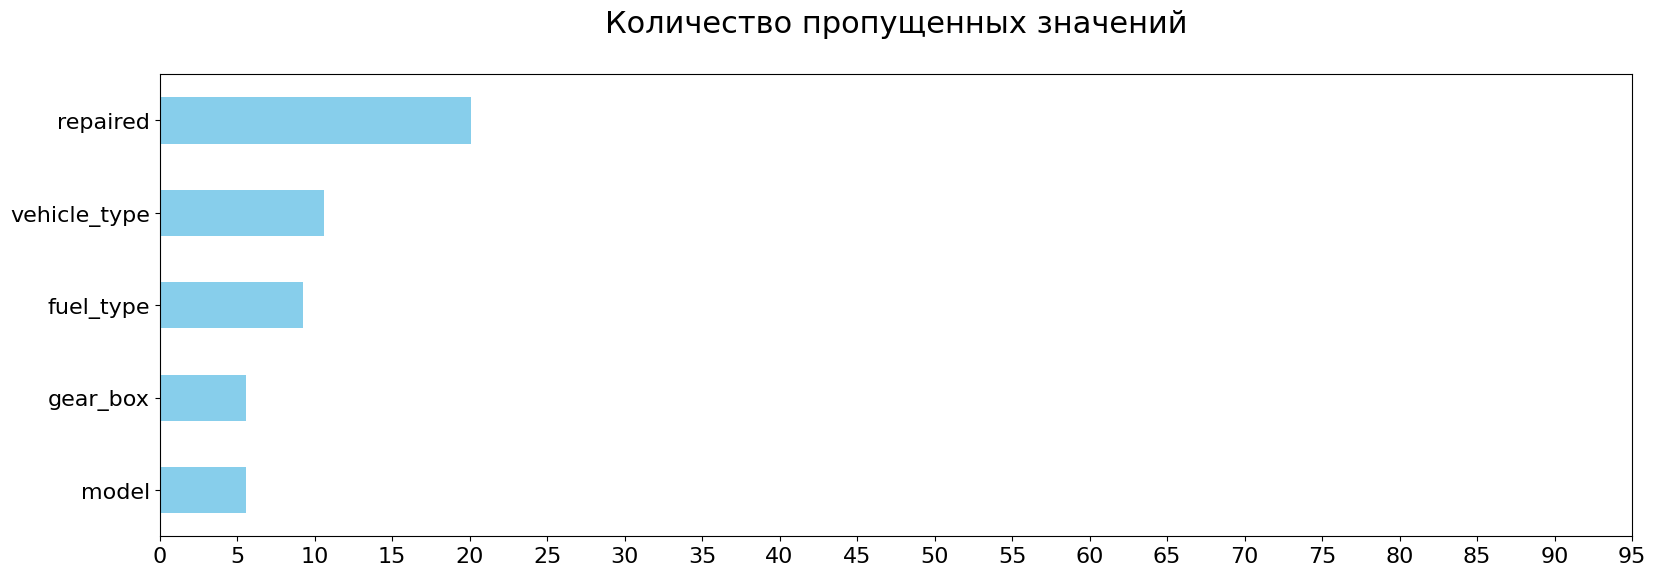

In [462]:
pass_value_barh(data)

### repaired

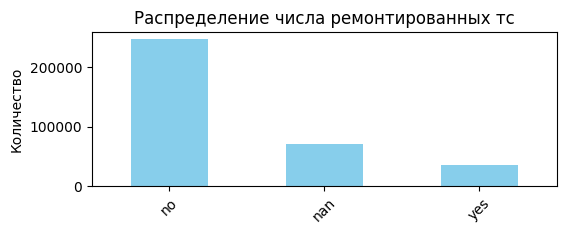

In [463]:
data['repaired'].value_counts(dropna=False).plot(kind='bar',
                                                 color='skyblue',
                                                 figsize = (6,2))
plt.title('Распределение числа ремонтированных тс')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

### vehicle_type

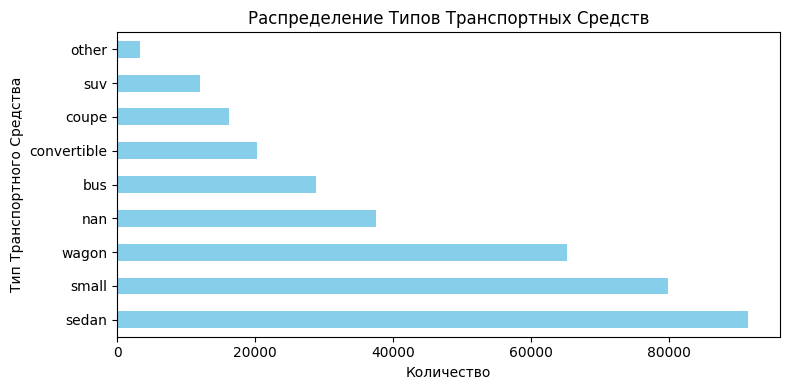

In [464]:
data['vehicle_type'].value_counts(dropna=False).plot(kind='barh',
                                                     color='skyblue',
                                                     figsize = (8,4))
plt.title('Распределение Типов Транспортных Средств')
plt.ylabel('Тип Транспортного Средства')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

### fuel_type

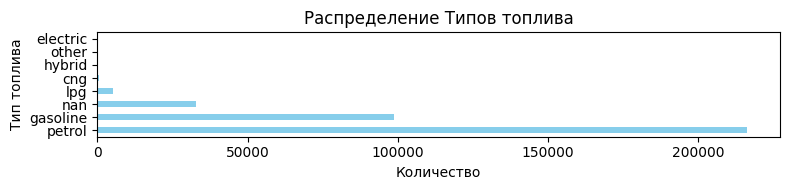

In [465]:
data['fuel_type'].value_counts(dropna=False).plot(kind='barh',
                                                  color='skyblue',
                                                  figsize = (8,2))
plt.title('Распределение Типов топлива')
plt.ylabel('Тип топлива')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

### gear_box

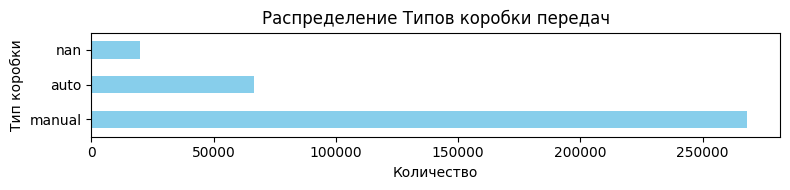

In [466]:
data['gear_box'].value_counts(dropna=False).plot(kind='barh',
                                                  color='skyblue',
                                                  figsize = (8,2))
plt.title('Распределение Типов коробки передач')
plt.ylabel('Тип коробки')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

### model

следующий признак один из важнейших, но график строить нецелесообразно из-за того, что в данном признаке содержится слишком много уникальных названий моделей автомобилей.

Значения категориальные и следовательно заполняем заглушкой no_info

### Заполняем пропуски

In [467]:
data = data.fillna('no_info')

пропусков не осталось


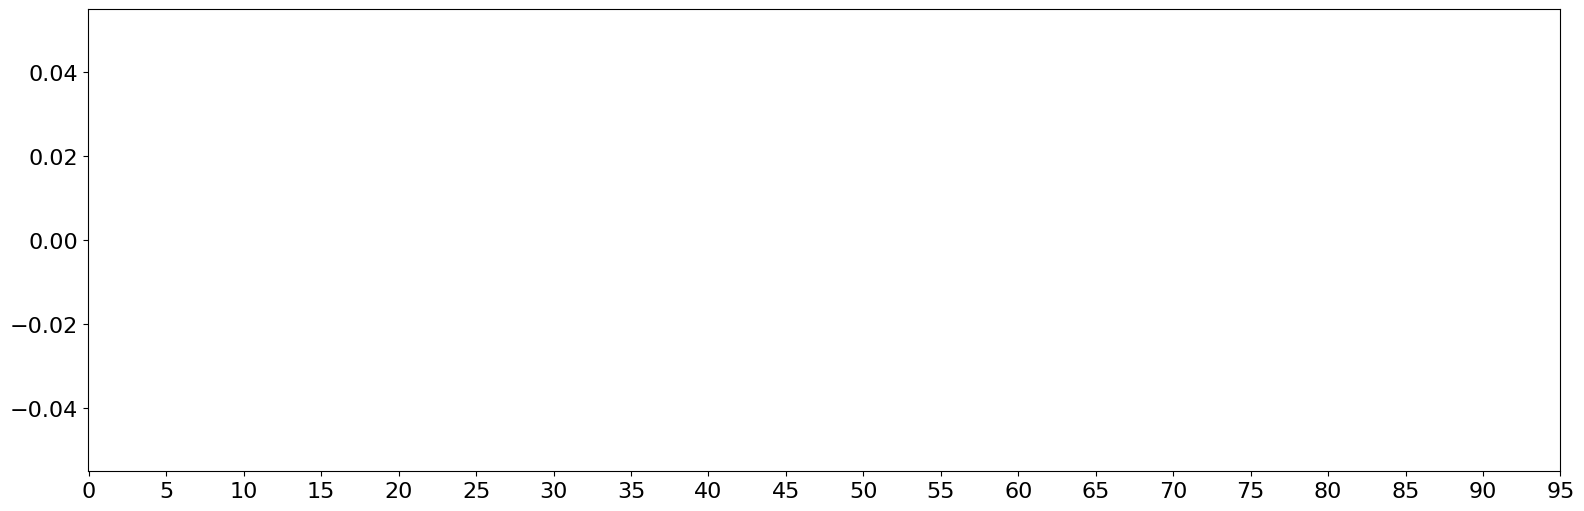

In [468]:
pass_value_barh(data)

In [469]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06



Пропуски имеются исключительно в категориальных признаках.

Пропуски заполнены.

## Анализ признаков на аномалии

In [470]:
data.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gear_box              object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
pictures_amount        int64
postal_code            int64
last_seen             object
dtype: object

Для анализа распределения воспользуемся графиками.

Для этого заранее подготовим переменные в которых сохраним названия признаков содержащих одинаковый тип данных.

In [471]:
categorical_columns = data.select_dtypes(include = 'object').columns
numeric_columns = data.select_dtypes(include = 'number').columns

### Числовые признаки

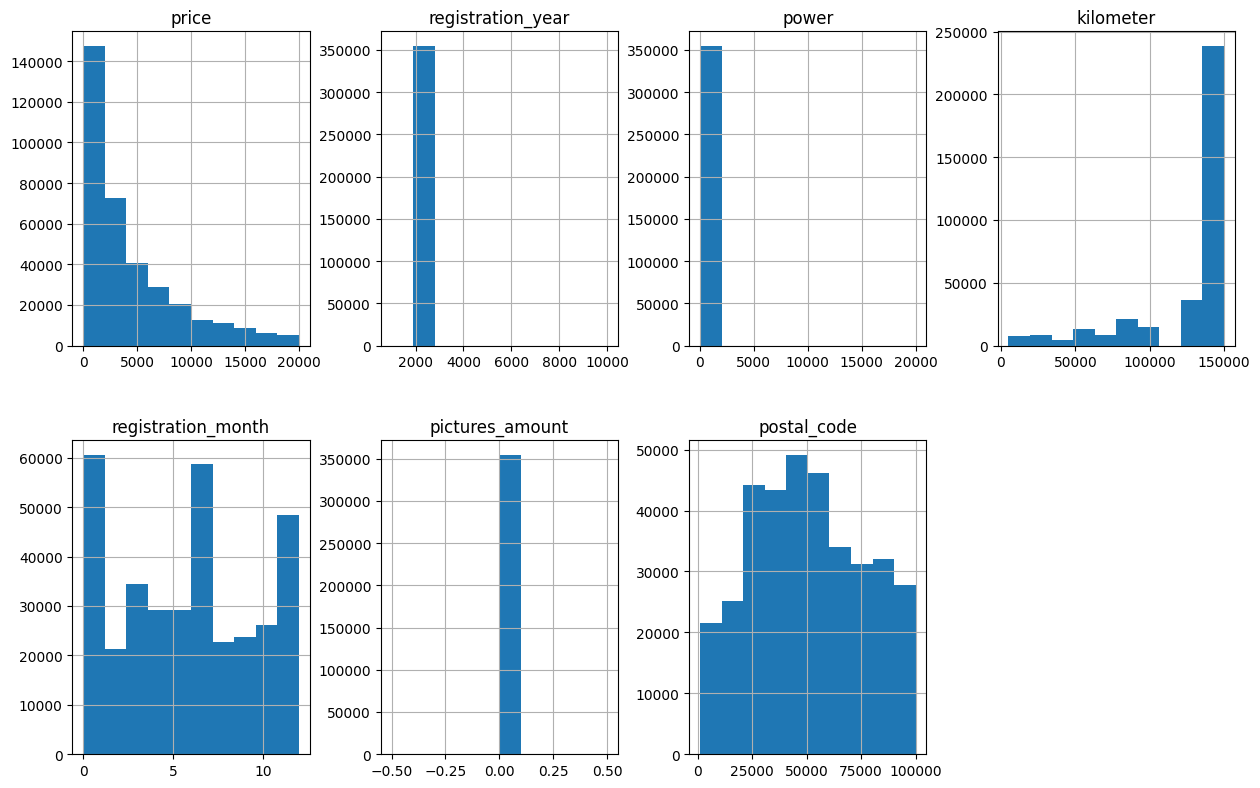

In [472]:
# Оценим визуально признаки, их распределение
data[numeric_columns].hist(layout=(4,4),figsize=(15, 20));

- price нужно изучить на наличие аномалий
- в признаке registration_year очевидно имееются аномалии
- признак power нужно проверить на систему в которой выражена мощность.
- kilometer имеются редкие значения, но аномалий не видно на этом графике
- pictures_amount содержат отрицательные значения, что является аномалией
- sale_month, postal_code в обработке и анализе не нуждаются

#### registration_year

Начнем с этого признака, так как там несомненные аномалии

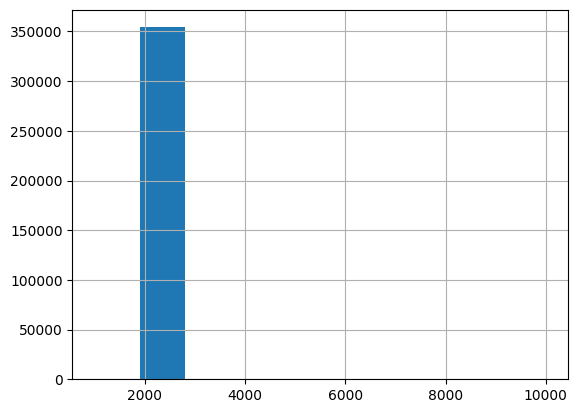

In [473]:
data['registration_year'].hist();

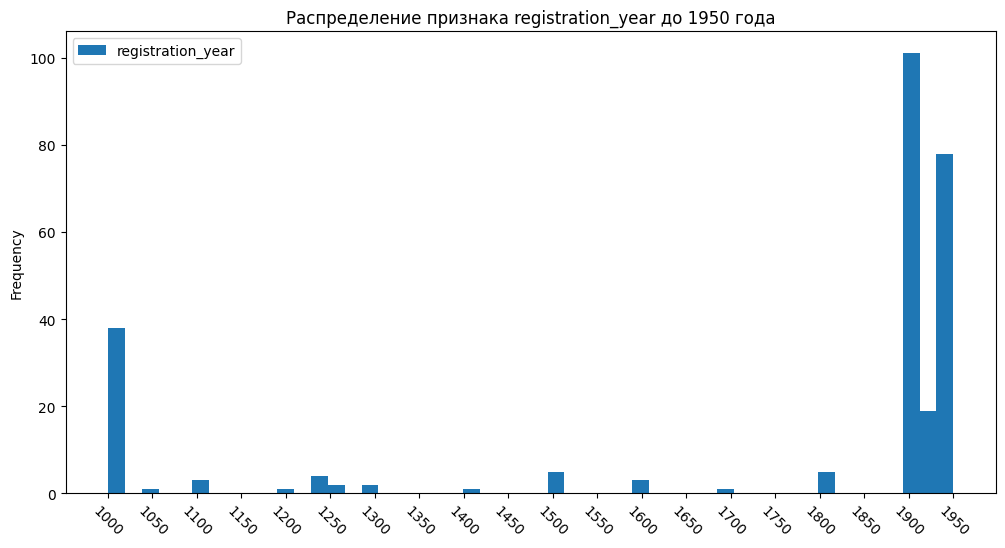

In [474]:
data[['registration_year']].plot(
    kind = 'hist',
    range = (int(data[['registration_year']].min()), 1950),
    bins = 50,
    xticks=[x for x in range(1000, 1970, 50)],
    rot = -45,
    figsize = (12,6)
);
plt.title ('Распределение признака registration_year до 1950 года');

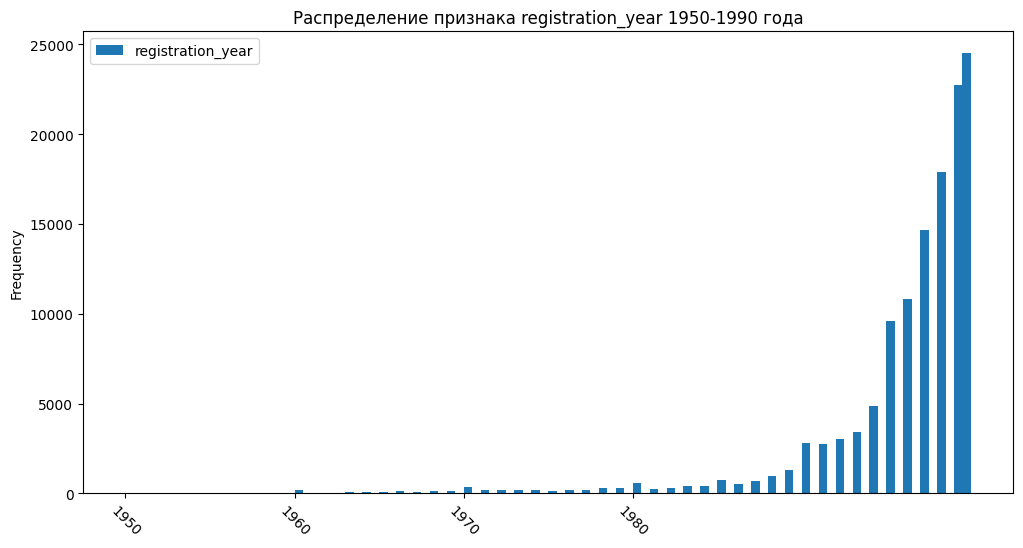

In [475]:
data[['registration_year']].plot(
    kind = 'hist',
    range = (1950, 2000),
    bins = 100,
    xticks=[x for x in range(1950, 1990, 10)],
    rot = -45,
    figsize = (12,6)
);
plt.title ('Распределение признака registration_year 1950-1990 года');

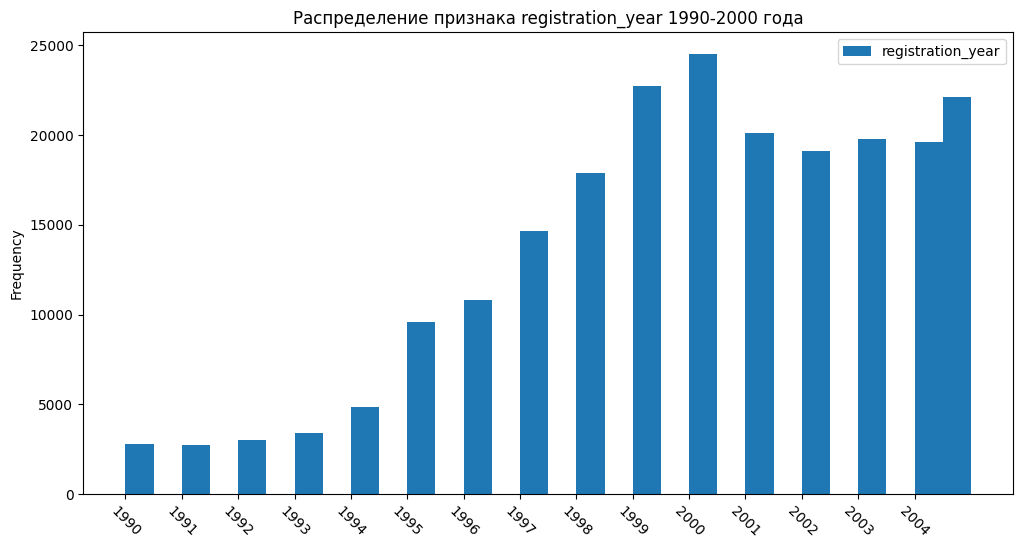

In [476]:
data[['registration_year']].plot(
    kind = 'hist',
    range = (1990, 2005),
    bins = 30,
    xticks=[x for x in range(1990, 2005, 1)],
    rot = -45,
    figsize = (12,6)
);
plt.title ('Распределение признака registration_year 1990-2000 года');

In [477]:
data['registration_year'].quantile([.03, .04, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

,0.03,0.04,0.05,0.10,0.50,0.70,0.95,0.98
registration_year,1990.0,1991.0,1992.0,1995.0,2003.0,2007.0,2016.0,2017.0


Оставляем объекты зарегистрированные в период с 1990 г по 2017.

In [478]:
data = data.loc[(data['registration_year']>1990) & (data['registration_year']<=2017)]
data.shape[0]

337805

,0.03,0.04,0.05,0.10,0.50,0.70,0.95,0.98
registration_year,1994.0,1994.0,1995.0,1996.0,2003.0,2007.0,2016.0,2017.0


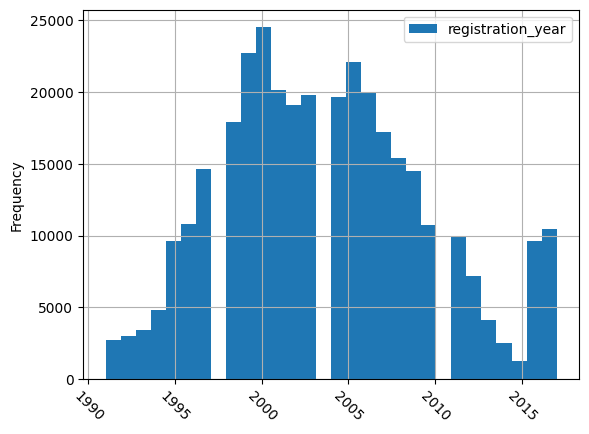

In [479]:
data[['registration_year']].plot(kind = 'hist',
                                 bins = 30,
                                 rot = -45,
                                 xticks = [x for x in range(1990, 2017, 5)],
                                 grid = True)
data['registration_year'].quantile([.03, .04, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

####  price

,count,mean,std,min,25%,50%,75%,max
price,337805.0,4437.472006,4518.00206,0.0,1099.0,2750.0,6460.0,20000.0


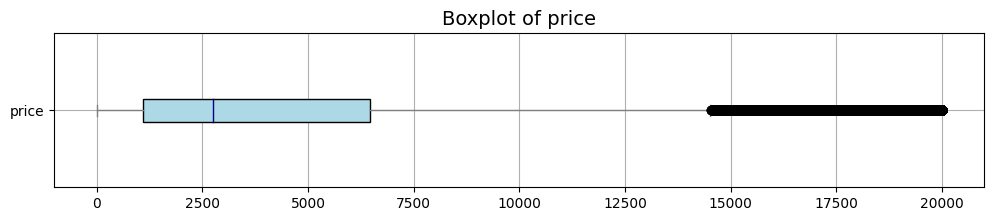

In [480]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
# Посмотрим на распределение
data['price'].describe().to_frame().transpose()

Мы видим, что присутствуют объекты с нулевой стоимостью, это явные аномалии.
Для стоимости автомобиля такой разбег по стоимости вполне допустим при условии что остальные признаки не противоречат, например высокая стоимость для автомобиля с большим пробегом, возрастом и марки "дешевого" ценового сегмента. И здесь сложнее сделать вывод по выбросам, так как очевидно, что автомобили премиум сегмента и очень старые автомобили (которые продают на запчасти или подросткам) будут сильно различаться в цене.


In [481]:
data['price'].quantile([.02, .03, .04, .05,.1,.50, .7, .95, .98]).to_frame().transpose()


,0.02,0.03,0.04,0.05,0.10,0.50,0.70,0.95,0.98
price,0.0,1.0,150.0,200.0,500.0,2750.0,5400.0,14600.0,17499.0


In [482]:
data.loc[data['price']==0].shape[0]

9474

Мы получаем, что 2.67% данных это объекты с нулевой стоимостью.
Их определенно нужно удалить. Иначе наши предсказания с высокой вероятностью будут иметь большее число отрицательных значений, что невозможно и потребуется более тщательная постобработка предсказаний.

In [483]:
data = data.loc[data['price']>0]
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06


,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,1.0,350.0,590.0,2900.0,5500.0,14800.0,17500.0


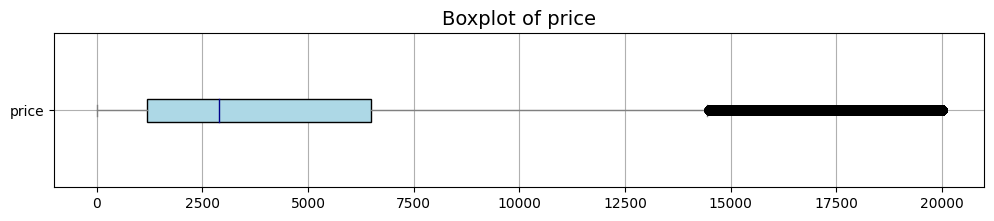

In [484]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

Избавимся от редких значений: оставим только объекты с ценой выше 200 евро, что соответствует 5 квантилю.

In [485]:
data = data.loc[data['price']>200]
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06


,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,230.0,499.0,650.0,2997.5,5700.0,14900.0,17500.0


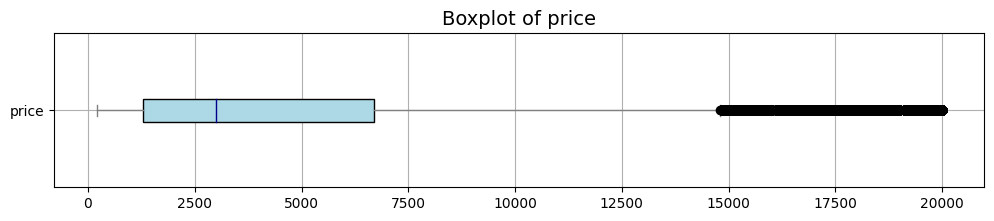

In [486]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

In [487]:
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,230.0,499.0,650.0,2997.5,5700.0,14900.0,17500.0


In [488]:
data[['price']].describe()

,price
count,320244.000000
mean,4677.668400
std,4519.019456
min,202.000000
25%,1299.000000
50%,2997.500000
75%,6700.000000
max,20000.000000


После удаления объектов с аномально низкой и редким значением стоимости мы видим, что:
-  средняя цена выросла с 4437 до 4670
- медианная стоимость незначительно упала с 2750 до 2700.0

Параметры выборки изменились в допустимых размерах.

Проанализируем объекты хвостовой части. Их мы рассмотрим совместно с пробегом и датой регистрацией автомобиля, так как большой пробег для высокой цены нелогичен.

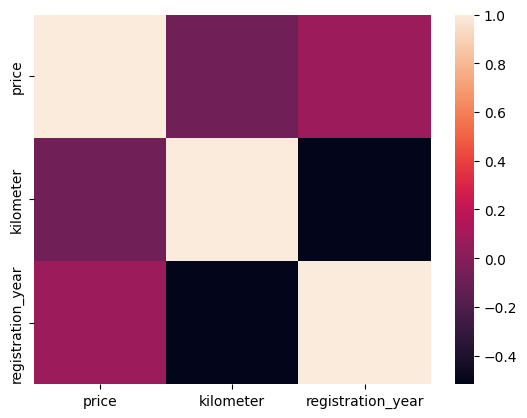

In [489]:
sns.heatmap(data.loc[data['price']>15000, ['price','kilometer','registration_year']]\
                              .sort_values(
                                          by = ['price','kilometer'],
                                          ascending=False)\
                               .corr());


Эти объекты действительно похожи на аномальные, так как не видно четкой зависимости между этими параметрами, тогда как в реальной жизни будет существовать зависимость:
- старше автомобиль- больше пробег
- больше пробег - ниже стоимость.
Если зависимость между годом регистрации и пробегом мы наблюдаем (хоть и не убедительную), то зависимость цены от этих параметров мы не наблюдаем вовсе.



In [490]:
data.loc[data['price']>15000, 'kilometer'].value_counts().to_frame().transpose()

,150000,125000,60000,70000,50000,80000,90000,100000,40000,30000,20000,10000,5000
kilometer,3924,1635,1055,1016,1006,988,928,908,901,794,697,254,167


In [491]:
data.loc[data['price']>15000, 'registration_year'].value_counts().sort_values(ascending = False).to_frame().head(15).transpose()

,2011,2012,2010,2009,2013,2008,2014,2007,2006,2015,2005,2004,2017,2003,2016
registration_year,2186,1938,1729,1434,1391,1335,990,959,588,421,291,173,153,130,107


Посмотри на признак date_crawled (дата скачивания анкеты), чтобы понять когда сервис начал продавать автомобили

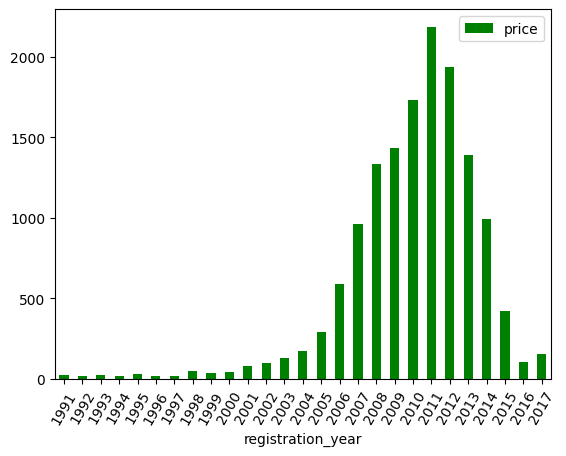

In [492]:
data.loc[data['price']>15000].groupby('registration_year')[['price']].count().plot(kind = 'bar',
                                                        rot = 60,
                                                        color = 'green');

In [496]:
pd.to_datetime(data['date_crawled']).dt.year.value_counts()


2016    320244
Name: date_crawled, dtype: int64

На этом графике мы видим, что объекты стоимостью > 15 тыс присутствуют во всех возрастных категориях, без исключений, что неправдоподобно.
Еще одна странная особенность, что наибольшее число дорогих объектов находятся в диапазоне 2007-2014 год, что странно, учитывая что все анкеты скачаны не позднее 2016 г, что говорит о том, что дата продажи не ранее 2016 г.
Значит объекты зарегистрированные в 2007 году к моменту продажи будут очень старые для такой стоимости.

Удалим объекты для которых справедливы 2 условия:
- цена выше 15 тыс
- registration_year < 2014

In [497]:
data.loc[(data['price']>=15000) & (data['registration_year']>2014)].shape[0]

714

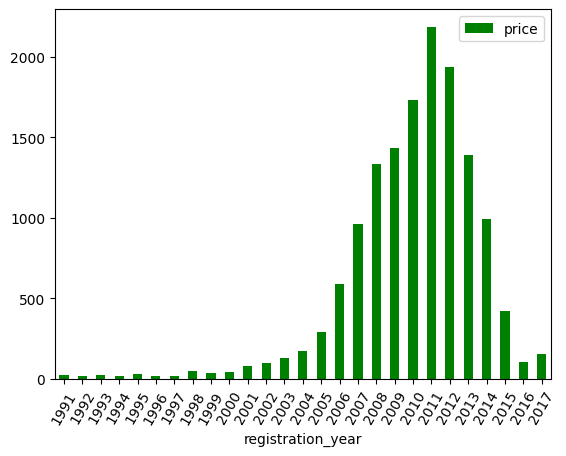

In [498]:
data.loc[data['price']>15000].groupby('registration_year')[['price']].count().plot(kind = 'bar',
                                                        rot = 60,
                                                        color = 'green');

In [504]:
index_to_drop = data[(data['price'] >= 15000) & (data['registration_year'] < 2014)].index
index_to_drop

Int64Index([], dtype='int64')

In [502]:
data.drop(index = index_to_drop, inplace=True)

KeyError: ignored

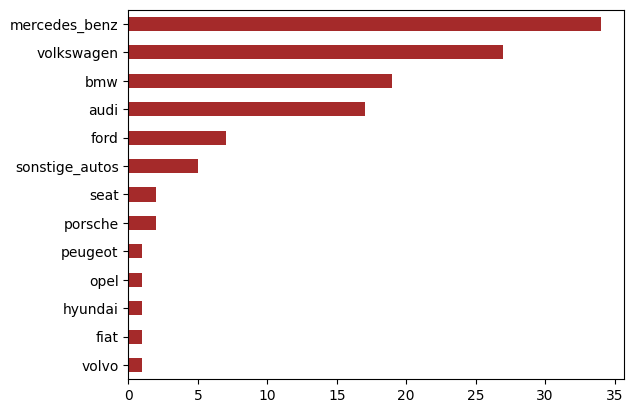

In [505]:
data.loc[(data['price']>=15000) & (data['kilometer']>100000), 'brand']\
              .value_counts(ascending = True)\
              .plot( kind = 'barh',
                    color = 'brown');

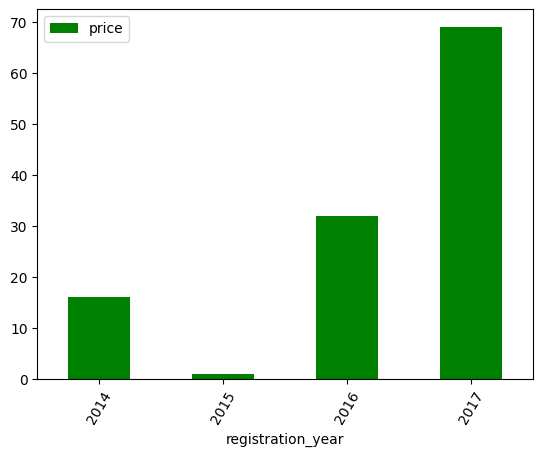

In [506]:
data.loc[(data['price']>=15000) & (data['kilometer']>100000)]\
                  .groupby('registration_year')[['price']]\
                  .count().plot(kind = 'bar',
                                rot = 60,
                                color = 'green');

<Axes: >

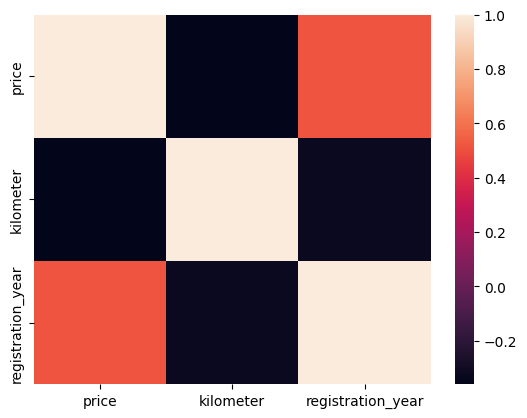

In [508]:
sns.heatmap(data[['price','kilometer','registration_year']].corr())

In [509]:
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,230.0,490.0,650.0,2800.0,5100.0,12400.0,14000.0


Теперь карта дешевых объектов не противоречит логике:
- высокая стоимость характерна для автомобилей премиум сегмента
- количество дорогих объектов (несмотря на высокий пробег) увеличивается по мере уменьшения возраста.

#### kilometer

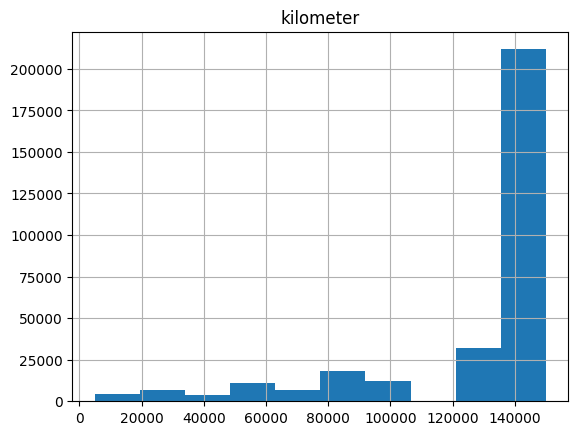

In [528]:
data[['kilometer']].hist();



####power

При анализе этого параметра будем исходить из того, что минимальная мощность это 20 л.с а максимальная 1000.

In [543]:
data.loc[(data['power']<=20) | (data['power']>1000)]


,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,70435,2016-04-07
32,2016-03-15,245,sedan,1994,no_info,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,44145,2016-03-17
37,2016-03-28,1500,no_info,2016,no_info,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,46483,2016-03-30
54,2016-03-17,4700,wagon,2005,manual,0,signum,150000,0,no_info,opel,no,2016-03-17,88433,2016-04-04
55,2016-03-26,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,56759,2016-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05,3299,no_info,2005,auto,0,outlander,150000,4,petrol,mitsubishi,no_info,2016-03-05,17034,2016-03-06
354346,2016-03-07,2600,no_info,2005,auto,0,c_klasse,150000,9,no_info,mercedes_benz,no_info,2016-03-07,61169,2016-03-08
354360,2016-04-02,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02,81825,2016-04-06
354363,2016-03-27,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,26624,2016-03-29


Очень большое количество аномальных значений которые удалять мы не будем из соображений сохранения данных.

Все объекты мы разделим на несколько категорий в зависимости от мощности.

- до 100 л.с.  Микроавтомобили и компактные автомобили, обычно это небольшие городские автомобили
-  от 100 до 200 л.с.   Это типичные легковые автомобили для повседневного использования.

- от 200 до 400 л.с. Бизнес-класс и премиум-автомобили

- от 300 л.с. до 500 л.с. Спортивные автомобили

- от 500 л.с. и выше. Это автомобили с экстремальной производительностью и инновационными технологиями.

Но обратим внимание на автомобили с мощностью более 200. Если они не соответствуют по марке и стоимости премиум сегменту то удалим, как аномалию.

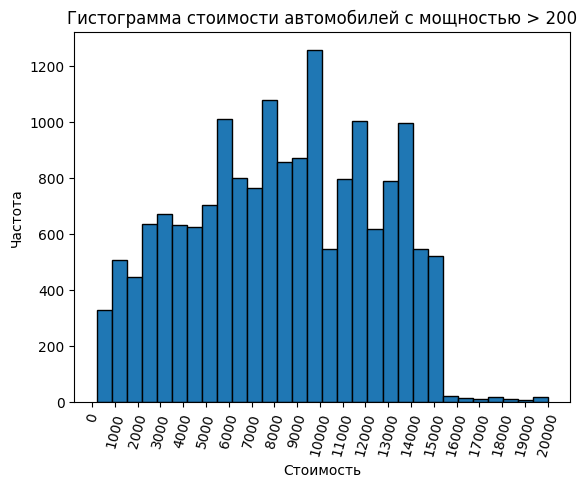

In [563]:
data_to_plot = data.loc[data['power'] > 200, 'price']
plt.hist(data_to_plot,
         bins=30,
         edgecolor='black')
plt.xlabel('Стоимость')
plt.xticks(range(0, int(data_to_plot.max()) + 1000, 1000),
           rotation=75)
plt.ylabel('Частота')
plt.title('Гистограмма стоимости автомобилей с мощностью > 200')
plt.show()

In [ ]:
data =

In [569]:
data.loc[(data['power'] > 200) & (data['price'] < 5000)].shape[0]

4120

#### pictures_amount

In [522]:
data['pictures_amount'].unique()

array([0])

Как видим этот признак неинформативен,  так как не содержит никакой информации и одинаков для всех объектов.

In [523]:
data = data.drop( 'pictures_amount', axis=1)
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,70435,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06


# old info

,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,15000.0,15200.0,15500.0,17500.0,18500.0,19990.0,19999.0


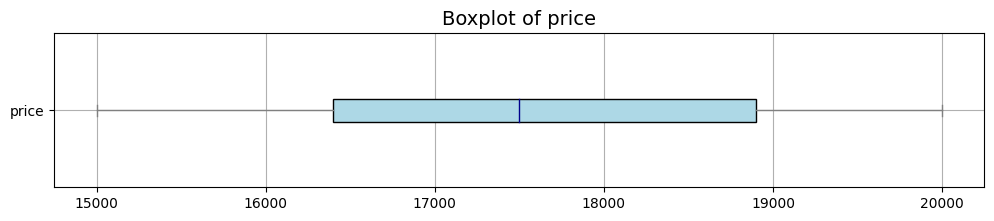

In [381]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

In [516]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'repaired', 'date_created', 'pictures_amount',
       'postal_code', 'last_seen'],
      dtype='object')

61207    737 days
4001     369 days
342275   261 days
86601    239 days
175103   211 days
           ...   
120091     0 days
120090     0 days
120089     0 days
120088     0 days
354368     0 days
Length: 343597, dtype: timedelta64[ns]

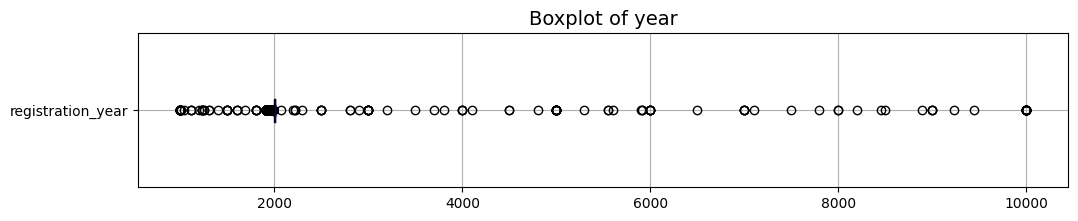

In [ ]:
data.boxplot(column=['registration_year'], figsize=(12, 2),
             vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            whiskerprops=dict(color='gray'),
            medianprops=dict(color='darkblue'),
            capprops=dict(color='gray')).set_title('Boxplot of year', fontsize=14);

In [ ]:
data['registration_year'].unique()

In [ ]:
numeric_columns.to_list()

['price',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'pictures_amount',
 'postal_code']

In [ ]:
for col in numeric_columns.to_list():
  print(col)
  print(data[col].value_counts().sort_values())
  print ()

price
10985        1
12870        1
2201         1
9769         1
12180        1
         ...  
1200      4594
1000      4649
1500      5394
500       5670
0        10772
Name: price, Length: 3731, dtype: int64

registration_year
3500        1
4100        1
1919        1
8200        1
1927        1
        ...  
2006    19900
2001    20124
2005    22109
1999    22728
2000    24490
Name: registration_year, Length: 151, dtype: int64

power
1241        1
902         1
682         1
2009        1
7529        1
        ...  
101     13298
150     14590
60      15897
75      24023
0       40225
Name: power, Length: 712, dtype: int64

kilometer
10000       1222
20000       3975
30000       4436
40000       4911
50000       6232
5000        6397
60000       7444
70000       8593
80000      10047
90000      11567
100000     14882
125000     36454
150000    238209
Name: kilometer, dtype: int64

registration_month
2     21267
8     22627
1     23219
9     23813
11    24186
12    24289
10    26099

**condition**

In [ ]:
train.loc[train['odometer']<30000, 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,119019.0,4.006383,0.81693,1.0,3.7,4.2,4.6,5.0


In [ ]:
train.loc[(train['odometer']<30000) & (train['condition'].isna()), 'condition'].shape[0]

640

In [ ]:
# заполним пропуски в признаке condition для объектов с пробегом менее 30 тыс средним значение равным 4
train.loc[(train['odometer']<30000) & (train['condition'].isna()), 'condition'] = train.loc[
    (train['odometer']<30000) & (train['condition'].isna()), 'condition'].fillna(4)

In [ ]:
test.loc[(test['odometer']<30000) & (test['condition'].isna()), 'condition'] = test.loc[
    (test['odometer']<30000) & (test['condition'].isna()), 'condition'].fillna(4)

In [ ]:
train.loc[(train['odometer']<30000) & (train['condition'].isna()), 'condition'].shape[0]

0

,count,mean,std,min,25%,50%,75%,max
condition,119659.0,4.006349,0.814742,1.0,3.7,4.2,4.6,5.0


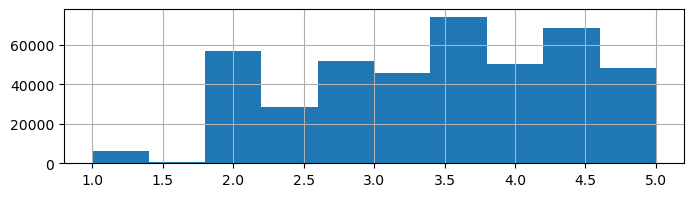

In [ ]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[train['odometer']<30000, 'condition'].describe().to_frame().transpose()

параметры не изменились

In [ ]:
train.loc[(train['odometer']<40000) & (train['odometer']>30000), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,55337.0,3.760945,0.754033,1.0,3.4,3.9,4.3,5.0


In [ ]:
train.loc[((train['odometer']<40000) & (train['odometer']>30000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']<40000) & (train['odometer']>30000) & train['condition'].isna()), 'condition'].fillna(3.76)

In [ ]:
test.loc[((test['odometer']<40000) & (test['odometer']>30000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']<40000) & (test['odometer']>30000) & test['condition'].isna()), 'condition'].fillna(3.76)

,count,mean,std,min,25%,50%,75%,max
condition,55626.0,3.76094,0.752071,1.0,3.4,3.9,4.3,5.0


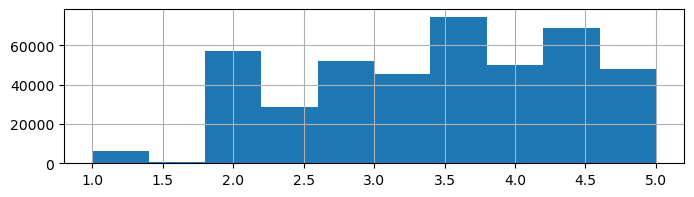

In [ ]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[(train['odometer']<40000) & (train['odometer']>30000), 'condition'].describe().to_frame().transpose()

In [ ]:
train.loc[(train['odometer']>40000) & (train['odometer']<50000), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,37744.0,3.650397,0.76257,1.0,3.2,3.7,4.2,5.0


In [ ]:
train.loc[((train['odometer']>40000) & (train['odometer']<50000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>40000) & (train['odometer']<50000) & train['condition'].isna()), 'condition'].fillna(3.65)

In [ ]:
test.loc[((train['odometer']>40000) & (test['odometer']<50000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>40000) & (test['odometer']<50000) & test['condition'].isna()), 'condition'].fillna(3.65)

,count,mean,std,min,25%,50%,75%,max
condition,38010.0,3.650395,0.759897,1.0,3.2,3.7,4.2,5.0


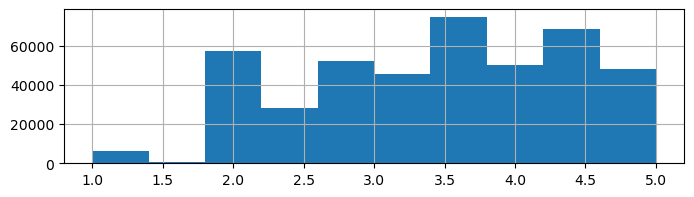

In [ ]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>40000) & (train['odometer']<50000) ), 'condition'].describe().to_frame().transpose()

In [ ]:
train.loc[((train['odometer']>50000) & (train['odometer']<60000) ), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,32103.0,3.487708,0.761446,1.0,2.9,3.6,4.1,5.0


In [ ]:
train.loc[((train['odometer']>50000) & (train['odometer']<60000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>50000) & (train['odometer']<60000) & train['condition'].isna()), 'condition'].fillna(3.5)

In [ ]:
test.loc[((test['odometer']>50000) & (test['odometer']<60000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>50000) & (test['odometer']<60000) & test['condition'].isna()), 'condition'].fillna(3.5)

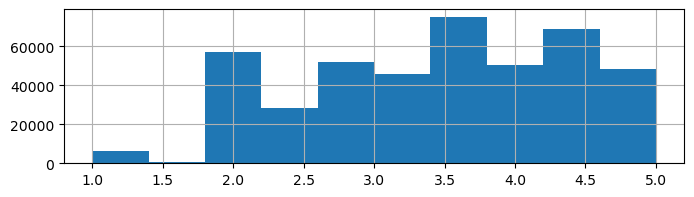

In [ ]:
# проверим распределение выборки после заполнения пропусков
train.loc[((train['odometer']>50000) & (train['odometer']<60000) ), 'condition'].describe().to_frame().transpose()
train['condition'].hist(figsize=(8,2));

In [ ]:
train.loc[((train['odometer']>60000) & (train['odometer']<80000) ), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,44320.0,3.341519,0.808816,1.0,2.8,3.5,3.9,5.0


In [ ]:
train.loc[((train['odometer']>60000) & (train['odometer']<80000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>60000) & (train['odometer']<80000) & train['condition'].isna()), 'condition'].fillna(3.45)

In [ ]:
test.loc[((train['odometer']>60000) & (test['odometer']<80000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>60000) & (test['odometer']<80000) & test['condition'].isna()), 'condition'].fillna(3.45)

,count,mean,std,min,25%,50%,75%,max
condition,45102.0,3.343399,0.801899,1.0,2.8,3.5,3.9,5.0


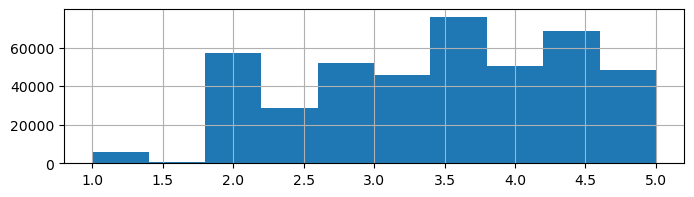

In [ ]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>60000) & (train['odometer']<80000) ), 'condition'].describe().to_frame().transpose()

In [ ]:
train.loc[((train['odometer']>80000) & (train['odometer']<100000) ), 'condition'].describe().to_frame().transpose()


,count,mean,std,min,25%,50%,75%,max
condition,39637.0,3.09258,0.829919,1.0,2.4,3.1,3.7,5.0


In [ ]:
train.loc[((train['odometer']>80000) & (train['odometer']<100000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>80000) & (train['odometer']<100000) & train['condition'].isna()), 'condition'].fillna(3)

In [ ]:
test.loc[((test['odometer']>80000) & (test['odometer']<100000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>80000) & (test['odometer']<100000) & test['condition'].isna()), 'condition'].fillna(3)

,count,mean,std,min,25%,50%,75%,max
condition,40894.0,3.089734,0.817221,1.0,2.5,3.0,3.7,5.0


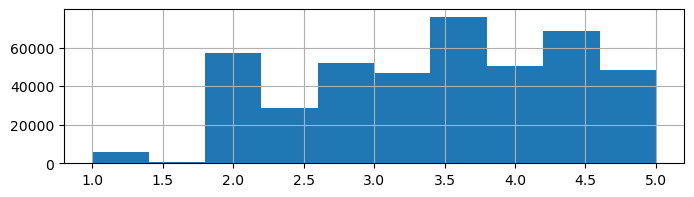

In [ ]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>80000) & (train['odometer']<100000) ), 'condition'].describe().to_frame().transpose()

In [ ]:
train.loc[((train['odometer']>100000) & (train['odometer']<150000) ), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,67842.0,2.740674,0.792235,1.0,2.0,2.7,3.4,5.0


In [ ]:
train.loc[((train['odometer']>100000) & (train['odometer']<150000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>100000) & (train['odometer']<150000) & train['condition'].isna()), 'condition'].fillna(2.7)

In [ ]:
test.loc[((test['odometer']>100000) & (test['odometer']<150000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>100000) & (test['odometer']<150000) & test['condition'].isna()), 'condition'].fillna(2.7)

,count,mean,std,min,25%,50%,75%,max
condition,71213.0,2.738749,0.773304,1.0,2.0,2.7,3.4,5.0


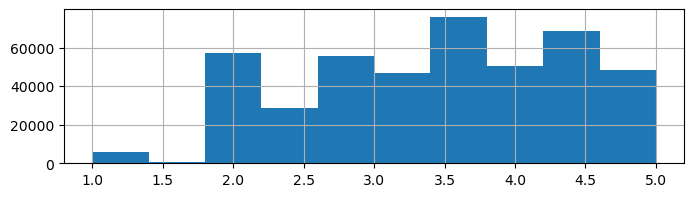

In [ ]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>100000) & (train['odometer']<150000) ), 'condition'].describe().to_frame().transpose()

In [ ]:
train['condition'].isna().sum()

2531

 Дальше заполнять по этому принципу не вижу смысла, так как уже разбег очень сильный в значениях, учитывая, что машины с пробегом после 150 тыс это уже редкие значения.

In [ ]:
train[['odometer']].quantile([0.02,0.05, 0.1, .5, .65, .75, .85, .93, .99]).transpose()

,0.02,0.05,0.10,0.50,0.65,0.75,0.85,0.93,0.99
odometer,5856.32,10475.0,15616.0,52098.0,77689.9,99272.0,125266.0,157501.38,226987.68


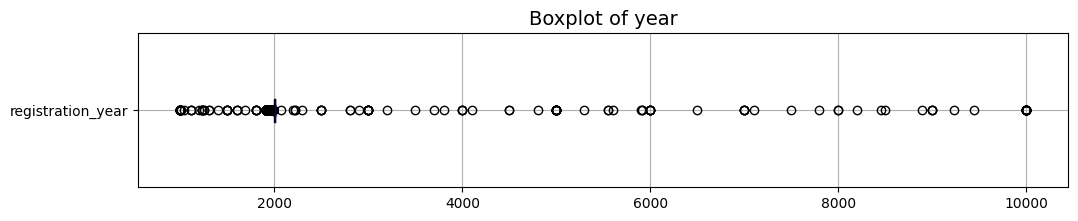

In [ ]:
train[['year']].quantile([0.02,0.05, 0.1, .5, .65, .75, .85, .9, .99]).transpose()


,0.02,0.05,0.10,0.50,0.65,0.75,0.85,0.90,0.99
year,2000.0,2002.0,2004.0,2012.0,2012.0,2013.0,2014.0,2014.0,2015.0


In [ ]:
test[['year']].quantile([0.02,0.05, 0.1, .5, .65, .75, .85, .9, .99]).transpose()


,0.02,0.05,0.10,0.50,0.65,0.75,0.85,0.90,0.99
year,2000.0,2002.0,2004.0,2012.0,2012.0,2013.0,2014.0,2014.0,2015.0


Видим, что в данных есть около 2% автомобилей до 2000 года производства.

**ODOMETER**

In [ ]:
# проанализируем признак odometer
train['odometer'].head()

0    111041.0
1     31034.0
2     35619.0
3    131301.0
4    127709.0
Name: odometer, dtype: float64

Этот признак содержит данные о пробеге автомобилей.
Чтобы было удобнее работать с этим признаком разделим все значения на 1000.

In [ ]:
train['odometer'] = train['odometer']/1000
train['odometer'].head()

0    111.041
1     31.034
2     35.619
3    131.301
4    127.709
Name: odometer, dtype: float64

In [ ]:
test['odometer'] = test['odometer']/1000
test['odometer'].head()

0    116.970
1      6.286
2     11.831
3     57.105
4     31.083
Name: odometer, dtype: float64

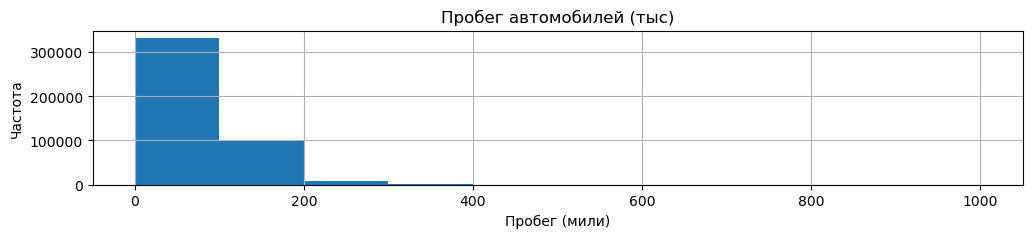

In [ ]:
train['odometer'].hist(figsize=(12, 2))
plt.title('Пробег автомобилей (тыс)')
plt.xlabel('Пробег (мили)')
plt.ylabel('Частота')
plt.show()


На графике видно, что основная масса автомобилей имеет пробег до 200 тыс, проанализируем количество автомобилей с пробегом более 200 тыс.

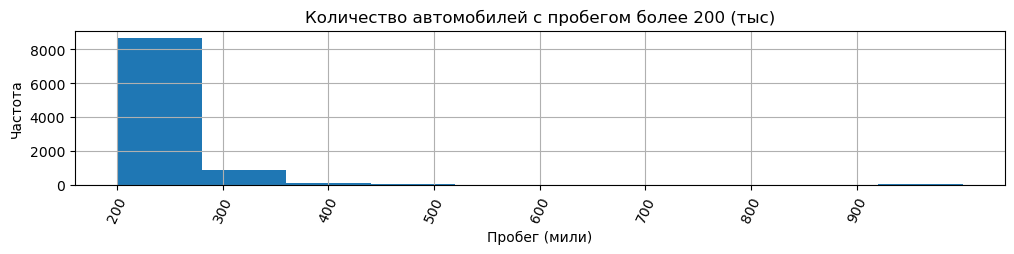

In [ ]:
# построим гистограмму для распределения количества автомобилей с пробегом от 200 тыс
train.loc[train['odometer']>200, 'odometer'].hist(figsize=(12, 2))
plt.xticks([j for j in range(200, 1000, 100)], rotation=65)
plt.title('Количество автомобилей с пробегом более 200 (тыс)')
plt.xlabel('Пробег (мили)')
plt.ylabel('Частота')
plt.show()


In [ ]:
train[['odometer']].quantile([0.02,0.05,0.5,.65, .75, .85, .9, .9825, .99]).transpose()


,0.0200,0.0500,0.5000,0.6500,0.7500,0.8500,0.9000,0.9825,0.9900
odometer,5.85632,10.475,52.098,77.6899,99.272,125.266,143.186,207.879475,226.98768


In [ ]:
test[['odometer']].quantile([0.02,0.05,0.5, .65, .75, .85, .9, .9825, .99]).transpose()

,0.0200,0.0500,0.5000,0.6500,0.7500,0.8500,0.9000,0.9825,0.9900
odometer,5.878,10.519,51.922,77.2082,98.8525,124.3126,142.5648,206.715335,226.68594


Лишь менее 2 процентов автомобилей имеют пробег более 200 тыс., это очень редкие значения, но учитывая что не можем их удалить, мы оставим эти данные.

Пробег менее 5 тыс километров так же редко встречается, и  это вполне логичное явление для автомобилей, со свежим сроком выпуска.

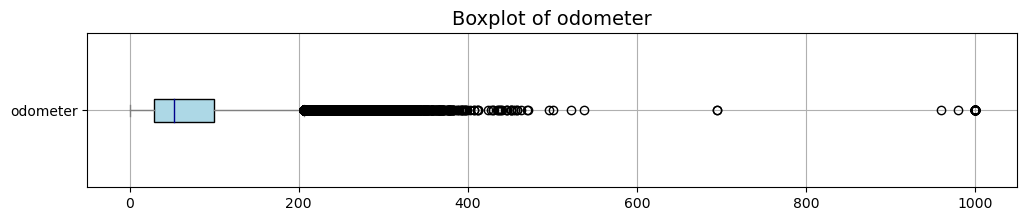

In [ ]:
train.boxplot(column=['odometer'], figsize=(12, 2),
             vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            whiskerprops=dict(color='gray'),
            medianprops=dict(color='darkblue'),
            capprops=dict(color='gray')).set_title('Boxplot of odometer', fontsize=14);

In [ ]:
#заполним пропуски заглушкой
train['odometer'].fillna(-999, inplace=True)
test['odometer'].fillna(-999, inplace=True)
print ('Количество пропущенных значений в odometer:')
print ('train', train['odometer'].isna().sum())
print ('test',test['odometer'].isna().sum())

Количество пропущенных значений в odometer:
train 0
test 0


**Проанализируем категориальные признаки**

In [ ]:
train[cat_features].head(10)

,make,model,trim,body,transmission,state,color,interior,seller
0,Ford,Edge,SEL,suv,automatic,md,black,black,santander consumer
1,Ford,Fusion,SE,Sedan,automatic,mo,black,black,ars/avis budget group
2,Nissan,Sentra,2.0 SL,sedan,automatic,nj,black,black,nissan-infiniti lt
3,HUMMER,H2,Base,suv,automatic,tx,gold,beige,wichita falls ford lin inc
4,Ford,Fusion,SEL,Sedan,automatic,md,black,black,purple heart
5,Lincoln,MKZ,Base,Sedan,automatic,mi,black,black,"ford motor credit company,llc"
6,pontiac,g6,4c,no_info,automatic,nc,silver,black,north state acceptance
7,Ford,Escape,SE,SUV,automatic,fl,blue,gray,fields bmw
8,Hyundai,Elantra,GLS,Sedan,automatic,oh,black,tan,dt inventory
9,Ford,Freestyle,Limited,wagon,automatic,oh,black,tan,wells fargo dealer services


В категориальных признаках мы видим следующие проблемы:
- разный регистр;
- пробелы;
- разные знаки внутри слов;
- цифры написаны слитно со словами.


In [ ]:
for column in cat_features:
    print (column, train[column].nunique())
    print ()

make 93

model 960

trim 1923

body 86

transmission 3

state 38

color 21

interior 18

seller 13025



In [ ]:
for column in cat_features:
    print (column, test[column].nunique())
    print ()

make 86

model 825

trim 1497

body 78

transmission 3

state 38

color 21

interior 18

seller 7623



In [ ]:
def transform_values(df):
    # заменяем пробелы на underscore
    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)

    # добавляем underscore между словом и цислом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)
    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df

In [ ]:
train = transform_values(train)
train.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,sale_year,sale_month
0,2011,ford,edge,sel,suv,automatic,md,4.2,111.041,black,black,santander_consumer,12500,2015,6
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31.034,black,black,ars/avis_budget_group,14500,2015,2
2,2012,nissan,sentra,2.0_sl,sedan,automatic,nj,2.2,35.619,black,black,nissan_infiniti_lt,9100,2015,6
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131.301,gold,beige,wichita_falls_ford_lin_inc,13300,2015,6
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127.709,black,black,purple_heart,1300,2015,2


In [ ]:
for column in cat_features:
    print (column, train[column].nunique())
    print ()

make 63

model 827

trim 1832

body 45

transmission 3

state 38

color 21

interior 18

seller 13018



In [ ]:
test = transform_values(test)
test.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sale_year,sale_month
0,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116.970,silver,black,lexus_of_stevens_creek,2015,1
1,2014,gmc,savana_cargo,,van,no_info,pa,4.4,6.286,white,gray,u_haul,2015,2
2,2013,nissan,murano,s,suv,automatic,oh,4.6,11.831,gray,black,nissan_infiniti_lt,2015,2
3,2013,chevrolet,impala,ls_fleet,sedan,automatic,fl,2.3,57.105,silver,black,onemain_rem/auto_club_of_miami_inc_dba_north_dad,2015,3
4,2013,nissan,titan,sv,crew_cab,automatic,tn,2.9,31.083,black,black,nissan_north_america_inc.,2015,6


In [ ]:
for column in cat_features:
    print (column, test[column].nunique())
    print ()

make 59

model 734

trim 1446

body 42

transmission 3

state 38

color 21

interior 18

seller 7619



In [ ]:
train['make'].nunique()

63

In [ ]:
train['make'] = train['make'].replace({'mercedes_benz': 'mercedes',
                                       'mercedes_b': 'mercedes',
                                       'vw': 'volkswagen',
                                      'land_rover':'landrover',
                                      'ford_truck':'ford',
                                      'mazda_tk':'mazda',
                                      'dodge_tk':'dodge',
                                      'gmc_truck':'gmc',
                                      'hyundai_tk':'hyundai',
                                     'ford_tk':'ford'})
print (train['make'].nunique())

55


In [ ]:
test['make'].nunique()

59

In [ ]:
test['make'] = test['make'].replace({'mercedes_benz': 'mercedes',
                                       'mercedes_b': 'mercedes',
                                       'vw': 'volkswagen',
                                      'land_rover':'landrover',
                                      'ford_truck':'ford',
                                      'mazda_tk':'mazda',
                                      'dodge_tk':'dodge',
                                      'gmc_truck':'gmc',
                                      'hyundai_tk':'hyundai',
                                     'ford_tk':'ford'})
print (test['make'].nunique())

54


**Посмотрим какие модели встречаются чаще всего**

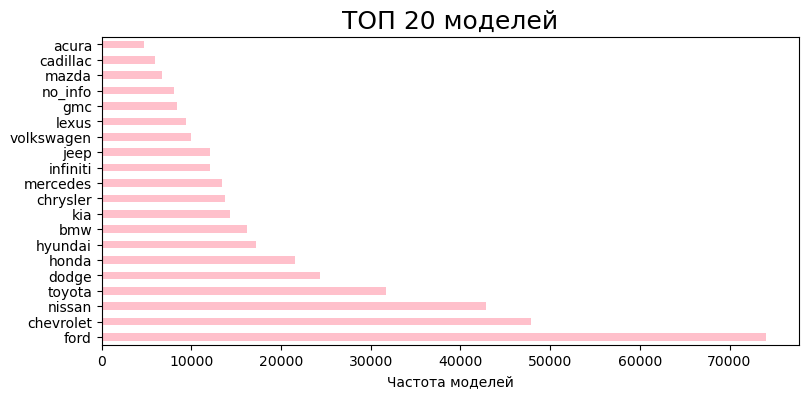

In [ ]:
plt.figure(figsize=(9,4))
train['make'].value_counts().nlargest(20).plot(kind='barh', color = 'pink')
plt.xlabel('Частота моделей')
plt.title("TOП 20 моделей",fontsize=18)
plt.show()

Почистим от неявных дубликатов самые распространенные марки.

In [ ]:
for make in train['make'].unique():
    print(make,
          train.loc[train['make']==make, 'model'].nunique(),
          train.loc[train['make']==make, 'model'].unique())
    print()

ford 64 ['edge' 'fusion' 'escape' 'freestyle' 'windstar' 'taurus' 'explorer'
 'f_150' 'flex' 'mustang' 'expedition' 'five_hundred' 'e_series_van'
 'focus' 'fusion_hybrid' 'explorer_sport_trac' 'f_250_super_duty' 'ranger'
 'fiesta' 'f_350_super_duty' 'f150' 'crown_victoria' 'e_series_wagon'
 'freestar' 'transit_connect' 'econoline_cargo' 'f_450_super_duty'
 'expedition_el' 'escort' 'c_max_hybrid' 'c_max_energi' 'escape_hybrid'
 'shelby_gt500' 'explorer_sport' 'taurus_x' 'expeditn' 'excursion'
 'econoline_wagon' 'fusion_energi' 'mustang_svt_cobra' 'f_150_heritage'
 'police' 'focus_st' 'thunderbird' 'e350' 'e150' 'excurs' 'e'
 'transit_van' 'crown' 'contour' 'e_250' 'e_150' 'transit_wagon' 'e250'
 'f250' 'windstar_cargo' 'f_150_svt_lightning' 'f350' 'expedit' 'tempo'
 'e_350' 'aspire' 'f_250']

nissan 31 ['sentra' 'murano' 'armada' 'altima' 'rogue' 'maxima' 'versa' 'pathfinder'
 'cube' 'rogue_select' 'frontier' '370z' 'quest' 'leaf' 'titan' 'xterra'
 'nv_cargo' 'juke' 'altima_hybrid' '350

In [ ]:
# удалим неявные дубликаты
train['model'] = train['model'].replace({'mountnr': 'mountaineer',
                                       'mazdaspeed_mazda3': 'mazdaspeed3',
                                      'mazdaspeed_mx_5_miata':'mx_5_miata',
                                      'e150':'e_150',
                                      'f150':'f_150',
                                      'e350':'e_350',
                                      'e250':'e_250',
                                          'expeditn': 'expedition',
                                         'expedit': 'expedition',
                                        'crown': 'crown_victoria',
                                         'excurs' : 'excursion',
                                         'e150' : 'e_150',
                                         'e250':'e_250'  ,
                                         'e350' :  'e_350' ,
                                         'f250':'f_250',
                                          'f150':'f_150',
                                         'f350':'f_350',
                                        'subrbn':'suburban',
                                        'e':'e_series',
                                        'silverado_2500':'silverado_2500hd',
                                         'silverado_3500': 'silverado_3500hd',
                                       'capt':'captiva',
                                       'uplandr':'uplander',
                                       's10':'s_10'})

In [ ]:
test['model'] = test['model'].replace({'mountnr': 'mountaineer',
                                       'mazdaspeed_mazda3': 'mazdaspeed3',
                                      'mazdaspeed_mx_5_miata':'mx_5_miata',
                                      'e150':'e_150',
                                      'f150':'f_150',
                                      'e350':'e_350',
                                      'e250':'e_250',
                                          'expeditn': 'expedition',
                                         'expedit': 'expedition',
                                        'crown': 'crown_victoria',
                                         'excurs' : 'excursion',
                                         'e150' : 'e_150',
                                         'e250':'e_250'  ,
                                         'e350' :  'e_350' ,
                                         'f250':'f_250',
                                          'f150':'f_150',
                                         'f350':'f_350',
                                        'subrbn':'suburban',
                                        'e':'e_series',
                                       'silverado_2500':'silverado_2500hd',
                                         'silverado_3500': 'silverado_3500hd',
                                       'capt':'captiva',
                                       'uplandr':'uplander',
                                       's10':'s_10'
                                      })

In [ ]:
for make in train['make'].unique():
    print(make,
          train.loc[train['make']==make, 'model'].nunique())
    print()

ford 55

nissan 31

hummer 5

lincoln 17

pontiac 19

hyundai 21

no_info 1

buick 14

chevrolet 66

honda 18

acura 14

cadillac 23

gmc 29

saab 4

dodge 29

mercedes 37

toyota 31

volkswagen 24

bmw 41

infiniti 35

chrysler 19

kia 14

jaguar 8

subaru 11

jeep 9

lexus 39

scion 6

fiat 3

suzuki 14

mazda 26

volvo 16

audi 27

mini 6

isuzu 7

mitsubishi 16

smart 2

porsche 8

landrover 13

saturn 12

ram 6

oldsmobile 12

mercury 15

bentley 8

fisker 1

maserati 7

tesla 1

rolls_royce 1

ferrari 3

plymouth 5

lamborghini 1

geo 2

aston_martin 3

daewoo 1

dot 1

airstream 1



**color**

In [ ]:
train['color'].value_counts()

black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off_white     1143
yellow         979
no_info        586
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

Пробовала уменьшить количество категорий в признаке, добавив признак other, но модель потеряла 0.3

**body**

In [ ]:
train['body'].value_counts().sort_index().index

Index(['access_cab', 'beetle_convertible', 'cab_plus', 'cab_plus_4',
       'club_cab', 'convertible', 'coupe', 'crew_cab', 'crewmax_cab',
       'cts_coupe', 'cts_v_coupe', 'cts_v_wagon', 'cts_wagon', 'double_cab',
       'e_series_van', 'elantra_coupe', 'extended_cab', 'g37_convertible',
       'g37_coupe', 'g_convertible', 'g_coupe', 'g_sedan', 'genesis_coupe',
       'granturismo_convertible', 'hatchback', 'king_cab', 'koup', 'mega_cab',
       'minivan', 'no_info', 'promaster_cargo_van', 'q60_convertible',
       'q60_coupe', 'quad_cab', 'ram_van', 'regular_cab', 'sedan', 'supercab',
       'supercrew', 'suv', 'transit_van', 'tsx_sport_wagon', 'van', 'wagon',
       'xtracab'],
      dtype='object')

In [ ]:
test['body'].value_counts().sort_index().index

Index(['access_cab', 'beetle_convertible', 'cab_plus', 'club_cab',
       'convertible', 'coupe', 'crew_cab', 'crewmax_cab', 'cts_coupe',
       'cts_v_coupe', 'cts_wagon', 'double_cab', 'e_series_van',
       'elantra_coupe', 'extended_cab', 'g37_convertible', 'g37_coupe',
       'g_convertible', 'g_coupe', 'g_sedan', 'genesis_coupe',
       'granturismo_convertible', 'hatchback', 'king_cab', 'koup', 'mega_cab',
       'minivan', 'no_info', 'promaster_cargo_van', 'q60_convertible',
       'q60_coupe', 'quad_cab', 'regular_cab', 'sedan', 'supercab',
       'supercrew', 'suv', 'transit_van', 'tsx_sport_wagon', 'van', 'wagon',
       'xtracab'],
      dtype='object')

Дубликатов не наблюдается.

In [ ]:
list(train.columns)

['year',
 'make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'condition',
 'odometer',
 'color',
 'interior',
 'seller',
 'sellingprice',
 'sale_year',
 'sale_month']

### Модели

In [ ]:
#Разделим выборки
train_data, validation = train_test_split(train, random_state=42)
print(train_data.shape[0])
print(validation.shape[0])

330177
110059


In [ ]:
#выделим обучающие признаки и целевой признак
X = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state','condition', 'odometer', 'color',
     'interior', 'seller', 'sale_year','sale_month']
y = ['sellingprice']

In [ ]:
train_pool = Pool(data=train_data[X],
                  label=train_data[y],
                  cat_features=cat_features)
print(train_pool.shape[0])

330177


In [ ]:
validation_pool = Pool(data=validation[X],
                       label=validation[y],
                  cat_features=cat_features)
print(validation_pool.shape[0])

110059


In [ ]:
test_pool = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features)
print(test_pool.shape[0])

440236


## RandomGridSearch

In [ ]:
# параметры для перебора
param_grid = {
    'iterations':[3000, 4000, 100],
    'learning_rate': [0.01, 0.10],
    'depth': [6, 15],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [ ]:
params = {
    'cat_features': cat_features,
    'eval_metric': 'MAPE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds':15
}

In [ ]:
#инициализируем модель
model = CatBoostRegressor(**params)

In [ ]:
now = datetime.datetime.now()

print(now)

2023-06-03 18:30:52.109498


In [ ]:
%%time
randomized_search_result = model.randomized_search(param_grid,
                                                   train_pool)
print (model.best_score_)

0:	learn: 0.9861259	test: 0.9846813	best: 0.9846813 (0)	total: 771ms	remaining: 51m 21s
100:	learn: 0.5148948	test: 0.4568692	best: 0.4568692 (100)	total: 57.3s	remaining: 36m 51s
200:	learn: 0.4445060	test: 0.3614411	best: 0.3614411 (200)	total: 1m 50s	remaining: 34m 57s
300:	learn: 0.4072675	test: 0.3234615	best: 0.3234615 (300)	total: 2m 47s	remaining: 34m 19s
400:	learn: 0.3890189	test: 0.3009126	best: 0.3009126 (400)	total: 3m 33s	remaining: 31m 56s
500:	learn: 0.3642763	test: 0.2764855	best: 0.2764855 (500)	total: 4m 29s	remaining: 31m 19s
600:	learn: 0.3448643	test: 0.2602953	best: 0.2602953 (600)	total: 5m 26s	remaining: 30m 44s
700:	learn: 0.3337896	test: 0.2505443	best: 0.2505443 (700)	total: 6m 22s	remaining: 30m 1s
800:	learn: 0.3257570	test: 0.2447208	best: 0.2447208 (800)	total: 7m 18s	remaining: 29m 9s
900:	learn: 0.3193707	test: 0.2402522	best: 0.2402522 (900)	total: 8m 12s	remaining: 28m 14s
1000:	learn: 0.3116992	test: 0.2363184	best: 0.2363184 (1000)	total: 9m 8s	rem

In [ ]:
now = datetime.datetime.now()

print(now)

In [ ]:
best_params = randomized_search_result['params']
best_params

In [ ]:
# оцениваем
y_pred = model.predict(validation_pool)

NameError: name 'model' is not defined

In [ ]:
rmse = mean_squared_error(validation[y], y_pred, squared=False)

#  MAPE
mape = mean_absolute_percentage_error(validation[y], y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

best_params = {'depth': 9,
               'iterations': 3000,
               'learning_rate': 0.07555198107934782,
               'l2_leaf_reg': 8.206677907347204,
               'cat_features': cat_features,
    'eval_metric': 'MAPE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds' : 15}

In [ ]:
fstrs = model.get_feature_importance(prettified=True)

fig, ax = plt.subplots()
fstrs.plot(x='Feature Id', y='Importances', kind='bar', ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("Значение")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
best_model = CatBoostRegressor(**best_params,
                               random_seed= 42,
                              verbose = 100,
                              iterations = 1600)

In [ ]:
%%time
# обучаем модель
best_model.fit(test_pool)
print (best_model.best_score_)

In [ ]:
y_pred_test = model.predict(test[X])
y_pred_test

In [ ]:
test_vin = pd.read_csv('/kaggle/input/copy-of-used-cars-price-prediction-ds18/test.csv')
test_vin['vin'].head()

In [ ]:
prediction = pd.DataFrame()
prediction.head()

In [ ]:
prediction['vin']=test_vin['vin']
prediction.head()

In [ ]:
prediction['sellingprice']=y_pred_test
prediction.head()

In [ ]:
prediction.loc[prediction['sellingprice']<250, 'sellingprice']=250
prediction.loc[prediction['sellingprice']<250].shape[0]

In [ ]:
prediction.to_csv('result_10.csv', index = False)

**optuna**

In [ ]:
%%time
def objective(trial):
    # параметры модели
    params = {
        'iterations': trial.suggest_int('iterations',3000, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.09, 0.12),
        'depth': trial.suggest_int('depth', 9, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 6, 13),
        'random_state': 42,
        'cat_features': cat_features
    }

    # создаем CatBoost model
    model = CatBoostRegressor(**params)
    model.fit(train_pool, verbose=100)

    # предсказания на валидационной выборке
    predictions = model.predict(validation_pool)

    # важность признаков
    feature_importance = model.get_feature_importance(type = catboost.EFstrType.FeatureImportance)

    # считаем RMSE учитывая важность признаков
    weighted_rmse = mean_squared_error(validation[y], predictions, squared=False)

    for i, feature in enumerate(cat_features):
        if feature in feature_importance:
            weighted_rmse *= feature_importance[i]

    return weighted_rmse

# создаем study
study = optuna.create_study(direction='minimize')

# параметры оптимизации
study.optimize(objective, n_trials=5)

# выводим лучшие гиперпараметры и score
best_params = study.best_params
print(best_params)
print (study.best_score)

- Trial 0 finished with value: 2970.804679660054 and parameters:
        {'learning_rate': 0.06904379720513099,
         'depth': 4, 'l2_leaf_reg': 6.53124581544504}.
Best is trial 0 with value: 2970.804679660054.
- Trial 1 finished with value: 2645.160734104553 and parameters:
        {'learning_rate': 0.016135796081846888,
         'depth': 10,
         'l2_leaf_reg': 9.085872840748877}.
**Best is trial 1** with value: 2645.160734104553.

- Trial 2 finished with value: 2331.735905736237 and parameters:
        {'learning_rate': 0.08296668738211416, 'depth': 8, 'l2_leaf_reg': 7.135107529142273}.
**Best is trial 2** with value: 2331.735905736237.

- Trial 3 finished with value: 2632.341885837149 and parameters:
{'learning_rate': 0.06590501267678682, 'depth': 6, 'l2_leaf_reg': 6.5895906392406545}.
**Best is trial 2** with value: 2331.735905736237.

- Trial 4 finished with value: 3023.684888090036 and parameters:
{'learning_rate': 0.06177043795759185, 'depth': 4, 'l2_leaf_reg': 1.576680898996981}.
**Best is trial 2** with value: 2331.735905736237.

- Trial 5 finished with value: 2671.663728042232 and parameters: {'learning_rate': 0.03717361275601939, 'depth': 7, 'l2_leaf_reg': 6.827239019420514}.
**Best is trial 2** with value: 2331.735905736237.

- Trial 6 finished with value: 3022.7638694981424 and parameters: {'learning_rate': 0.02329988351343336, 'depth': 6, 'l2_leaf_reg': 8.916518291038535}. Best is trial 2 with value: 2331.735905736237.
- Trial 19 {'learning_rate':0.11597820817007716, 'depth': 13, 'l2_leaf_reg': 0.37933443309451775}
Trial 0 finished with value: 2228.906500663646 and parameters: {'learning_rate': 0.1260277017289611, 'depth': 9, 'l2_leaf_reg': 5.28804481342274}.
**Best is trial 0 with value: 2228.906500663646** .

Trial 11 finished with value: 2168.4043705101267 and parameters:
{'learning_rate': 0.11760637337592622, 'depth': 10, 'l2_leaf_reg': 3.0940654814585535}.
Best is trial 11 with value: 2168.4043705101267 .
Trial 13 finished with value: 2151.3242926113417 and parameters: {'learning_rate': 0.14511452039160722, 'depth': 10, 'l2_leaf_reg': 2.3470051891954804}.
Best is trial 13 with value: 2151.3242926113417.
arison
[I 2023-05-29 02:26:30,577] Trial 35 finished with value: 2191.9948118095012 and parameters: {'learning_rate': 0.12574274038155134, depth': 10, 'l2_leaf_reg': 1.09069287356834}. **Best is trial 25 with value: 2133.514994824393**

Trial 6 finished with value: 2141.4428581143584 and parameters: {'learning_rate': 0.11956200408474056, 'depth': 12, 'l2_leaf_reg': 8.811200920186481}.
est is trial 6 with value: 2141.4428581143584.
Trial 1 finished with value: 2168.0703315307874 and parameters: {'learning_rate': 0.11858257053327896, 'depth': 11, 'l2_leaf_reg': 9.270322764969738}. Best is trial 1 with value: 2168.0703315307874.
Trial 0 failed with parameters: {'iterations': 3304, 'learning_rate': 0.09040243409768059, 'depth': 12, 'l2_leaf_reg': 11.711812961320431} because of the following error: NameError("name 'categorical_features' is not defined")

#лучшие параметры
best_params = {'depth': 12,
               'iterations': 1000,
               'learning_rate': 0.11956200408474056,
               'l2_leaf_reg': 8.811200920186481}

In [ ]:
best_model = CatBoostRegressor(loss_function='RMSE',
                               random_seed=42,
                               verbose=False,
                               **best_params)

In [ ]:
%%time
# обучаем модель
best_model.fit(train_pool)
print (best_model.best_score_)

In [ ]:
y_pred = best_model.predict(validation_pool)

# MSE на валидационной
rmse = mean_squared_error(validation[y], y_pred, squared=False)

# MAPE на валидационной
mape = mean_absolute_percentage_error(validation[y], y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

In [ ]:
%%time
# обучаем модель
best_model.fit(test_pool)
print (best_model.best_score_)# оцениваем

In [ ]:
y_pred_test = best_model.predict(test[X])
y_pred_test

In [ ]:
predictions = pd.read_csv('/kaggle/input/copy-of-used-cars-price-prediction-ds18/sample_submission.csv')

In [ ]:
test_vin = pd.read_csv('/kaggle/input/copy-of-used-cars-price-prediction-ds18/test.csv')
test_vin['vin'].head()

In [ ]:
prediction = pd.DataFrame()
prediction.head()

In [ ]:
prediction['vin']=test_vin['vin']
prediction.head()


In [ ]:
prediction['sellingprice']=y_pred_test
prediction.head()

In [ ]:
prediction.to_csv('result8.csv', index = False)
#result.to_json('/Users/anzhelikaboltneva/Desktop/KAGGLE/predictions.json', orient='records')

In [ ]:
then = datetime.datetime.now()
print ('Выполнение тетрадки началось в: ', now.time())
print ('Выполнение тетрадки закончилось в: ', then.time())